Es wird entschieden keine der Spalten zu löschen, da diese für eine spätere Analyse möglicherweise wichtig sind.
Vielmehr sollen für die Durchführung des LDAs lediglich englische Lieder im Datensatz behalten werden.

In [1]:
# Importe
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
import gensim.corpora as corpora

In [2]:
# song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\DIE_DATEN\datensatz.csv')

# song_data = song_data[(song_data['Language'] == 'en')]

# song_data.to_csv("outData.csv", index=False)

song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\outData.csv')

song_data_subset = song_data.head(100)

## Data Cleaning

In [3]:
# Remove the columns
song_data_subset = song_data_subset[['Genre', 'Lyrics']]
# Print out the first rows of papers
song_data_subset

,Genre,Lyrics
0,Rock,"It starts with pain, followed by hate\nFueled ..."
1,Rock,Freedom!\nAlone again again alone\nPatiently w...
2,Rock,"Biting the hand that feeds you, lying to the v..."
3,Rock,You say you know just who I am\nBut you can't ...
4,Rock,My heart is beating faster can't control these...
...,...,...
95,Rock,We walk alone\nIn the unknown\nWe live to win ...
96,Rock,We walk alone\nIn the unknown\nWe live to win ...
97,Rock,Searching through my reasons to fight the tide...
98,Rock,"It starts with pain, followed by hate\nFueled ..."


## Remove punctuation/lower casing

In [4]:
# Remove punctuation
song_data_subset['song_text_processed'] = \
song_data_subset['Lyrics'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
song_data_subset['song_text_processed'] = \
song_data_subset['song_text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
song_data_subset['song_text_processed'].head()

0    it starts with pain followed by hate\nfueled b...
1    freedom\nalone again again alone\npatiently wa...
2    biting the hand that feeds you lying to the vo...
3    you say you know just who i am\nbut you can't ...
4    my heart is beating faster can't control these...
Name: song_text_processed, dtype: object

## Analyse für ein Lied

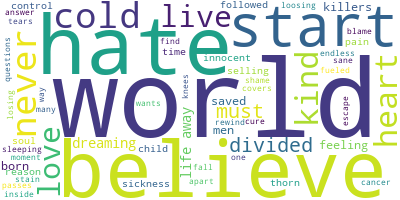

In [5]:
# Join the different processed titles together.
lyrics_for_one_song = song_data_subset.loc[0, 'song_text_processed']
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(lyrics_for_one_song)
# Visualize the word cloud
wordcloud.to_image()

In [8]:
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
import pandas as pd
from pprint import pprint

nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield gensim.utils.simple_preprocess(str(sentence), deacc=True)

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Assuming you have a DataFrame named 'songs_data' with a column 'lyrics'
song_data_subset['lyrics_processed'] = remove_stopwords(sent_to_words(song_data_subset['Lyrics']))

# Create a dictionary and a corpus for each song
corpora = []
dictionaries = []
lda_models = []
topics = []

num_topics = 5  # Change this to the desired number of topics

for i, song_lyrics in enumerate(song_data_subset['lyrics_processed']):
    # Create Dictionary
    id2word = gensim.corpora.Dictionary([song_lyrics])

    # Create Corpus
    corpus = [id2word.doc2bow(song_lyrics)]

    corpora.append(corpus)
    dictionaries.append(id2word)

    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)
    lda_models.append(lda_model)

    # Get the most dominant topic for each song
    song_topics = lda_model.get_document_topics(corpus[0], minimum_probability=0.0)
    dominant_topic = max(song_topics, key=lambda x: x[1])[0]
    topics.append(dominant_topic)

    # Print the Keywords in the topics for the current song
    print(f"Keywords for Song {i + 1} - Topic {dominant_topic}:")
    pprint(lda_model.print_topics())

# Add the 'topics' column to the DataFrame
song_data_subset['topics'] = topics

song_data_subset

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sdo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Keywords for Song 1 - Topic 4:
[(0,
  '0.030*"world" + 0.026*"believe" + 0.025*"hate" + 0.024*"never" + '
  '0.023*"cold" + 0.022*"dreaming" + 0.021*"divided" + 0.021*"must" + '
  '0.021*"away" + 0.021*"kind"'),
 (1,
  '0.054*"world" + 0.035*"hate" + 0.030*"never" + 0.029*"believe" + '
  '0.025*"love" + 0.025*"cold" + 0.024*"heart" + 0.023*"kind" + '
  '0.022*"divided" + 0.022*"dreaming"'),
 (2,
  '0.058*"world" + 0.031*"hate" + 0.029*"believe" + 0.029*"never" + '
  '0.028*"cold" + 0.022*"love" + 0.022*"must" + 0.022*"life" + 0.021*"kind" + '
  '0.021*"live"'),
 (3,
  '0.036*"world" + 0.027*"hate" + 0.024*"believe" + 0.023*"never" + '
  '0.022*"live" + 0.021*"kind" + 0.021*"away" + 0.021*"love" + 0.020*"cold" + '
  '0.019*"life"'),
 (4,
  '0.077*"world" + 0.040*"believe" + 0.037*"hate" + 0.033*"cold" + '
  '0.030*"never" + 0.028*"away" + 0.027*"heart" + 0.027*"must" + '
  '0.027*"divided" + 0.027*"life"')]
Keywords for Song 2 - Topic 0:
[(0,
  '0.109*"broken" + 0.058*"know" + 0.053*"ne

,Genre,Lyrics,song_text_processed,lyrics_processed,topics
0,Rock,"It starts with pain, followed by hate\nFueled ...",it starts with pain followed by hate\nfueled b...,"[starts, pain, followed, hate, fueled, endless...",4
1,Rock,Freedom!\nAlone again again alone\nPatiently w...,freedom\nalone again again alone\npatiently wa...,"[freedom, alone, alone, patiently, waiting, ph...",0
2,Rock,"Biting the hand that feeds you, lying to the v...",biting the hand that feeds you lying to the vo...,"[biting, hand, feeds, lying, voice, inside, re...",0
3,Rock,You say you know just who I am\nBut you can't ...,you say you know just who i am\nbut you can't ...,"[say, know, imagine, waits, across, line, thou...",0
4,Rock,My heart is beating faster can't control these...,my heart is beating faster can't control these...,"[heart, beating, faster, control, feelings, an...",0
...,...,...,...,...,...
95,Rock,We walk alone\nIn the unknown\nWe live to win ...,we walk alone\nin the unknown\nwe live to win ...,"[walk, alone, unknown, live, win, another, vic...",4
96,Rock,We walk alone\nIn the unknown\nWe live to win ...,we walk alone\nin the unknown\nwe live to win ...,"[walk, alone, unknown, live, win, another, vic...",3
97,Rock,Searching through my reasons to fight the tide...,searching through my reasons to fight the tide...,"[searching, reasons, fight, tide, thing, works...",4
98,Rock,"It starts with pain, followed by hate\nFueled ...",it starts with pain followed by hate\nfueled b...,"[starts, pain, followed, hate, fueled, endless...",2


c:\Users\sdo\AppData\Local\anaconda3\envs\DataScience\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\sdo\AppData\Local\anaconda3\envs\DataScience\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\sdo\AppData\Local\anaconda3\envs\DataScience\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\sdo\AppData\Local\anaconda3\envs\DataScience\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

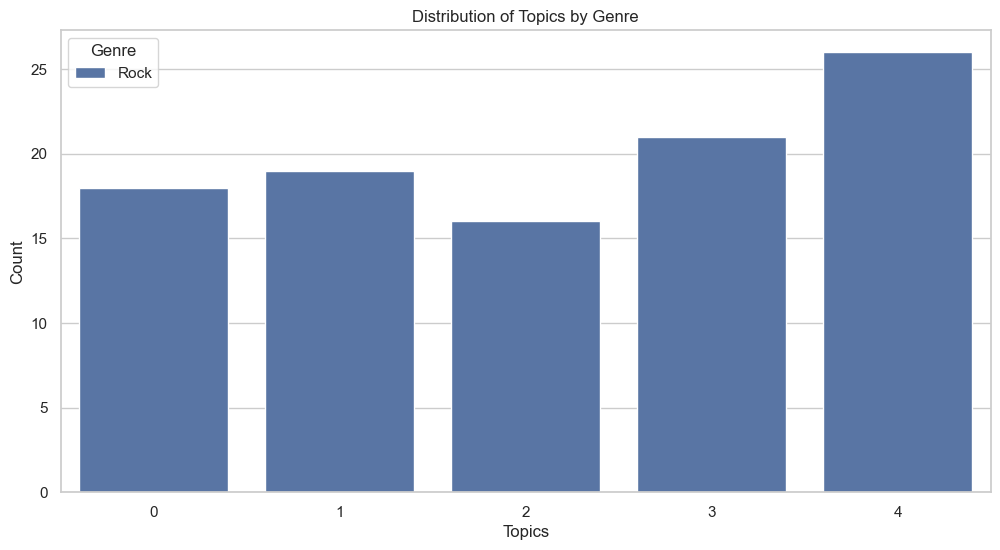

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named song_data with 'lyrics_processed' and 'Genre' columns

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.countplot(x='topics', hue='Genre', data=song_data_subset)

# Set plot labels and title
plt.title('Distribution of Topics by Genre')
plt.xlabel('Topics')
plt.ylabel('Count')

# Show the plot
plt.show()